In [1]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import missingno as msno

In [3]:
# 数据加载
data = pd.read_csv('./data.csv')
pd.set_option('display.max_columns', None)
data.drop(['user_id','ip'], axis=1, inplace=True)
print(data.shape)
data.head()

(642751, 47)


,role_level,p_model,sys_ver,net_w,net_type,sdk_no,u1,u2,u3,u4,u5,u6,g7,g8,g9,g10,is_create_role,is_create_no,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,server_sum,rollsrv,m1,m2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,is_pay,s1,s2,s3,s4,s5,s6,s7,city
0,4,PCAM10,9,4g,0.0,4005000,1,1,1,1,0.0,0.0,136657,151468,129869,1813367,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,0.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425,广州
1,4,HRY-AL00a,10,wifi,0.0,4005000,1,1,1,1,0.0,0.0,136657,151468,129869,1813367,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,0.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425,秦皇岛
2,0,HRY-AL00a,10,4g,0.0,4005000,1,1,1,1,0.0,0.0,2799,2883,2463,20322,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,32322.0,240.0,90.0,92.0,85.0,34.900000,0.029500,0.000000,45.0,55.0,49.0,0.0,0.011810,0.032154,0.031911,0.034511,0.500000,0.597826,0.576471,NaN
3,73,OPPO A59s,5.1,NaN,1.0,4005000,1,1,1,1,0.0,0.0,9564,10386,9338,222150,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,408350.0,5562.0,723.0,737.0,717.0,60.310859,0.528357,0.191837,117.0,151.0,123.0,0.0,0.025037,0.075596,0.070961,0.076783,0.161826,0.204885,0.171548,上海
4,226,VOG-AL00,10,4g,2.0,3003001,1,1,1,1,0.0,0.0,17669,19404,12415,429231,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,1577912.0,3730.0,760.0,772.0,680.0,64.489008,3.191399,0.060858,196.0,260.0,162.0,0.0,0.008690,0.043013,0.039786,0.054772,0.257895,0.336788,0.238235,北京


In [4]:
data['net_w'].value_counts()

wifi            314466
4g              158188
notReachable     15016
未知网络              3568
4G                2382
WIFI              1250
3g                1089
other              322
2g                 239
3G                  11
3.5G HSDPA           6
LTE                  6
3.5g                 6
2G                   5
none                 3
2.75G EDGE           1
unknown              1
Name: net_w, dtype: int64

In [10]:
# 处理net_w异常数据
data['net_w'].replace('WIFI', 'wifi', inplace=True)
data['net_w'].replace('4G', '4g', inplace=True)
data['net_w'].replace(['未知网络','none','notReachable','other','LTE'],'unknown', inplace=True)
data['net_w'].replace(['2.75G EDGE','2G'], '2g', inplace=True)
data['net_w'].replace(['3.5g', '3G', '3.5G HSDPA'], '3g', inplace=True)
data['net_w'].fillna('unknown', inplace=True)
data['net_w'].value_counts()

wifi       315716
unknown    165108
4g         160570
3g           1112
2g            245
Name: net_w, dtype: int64

In [17]:
# net_w进行one_hot编码
data = pd.get_dummies(data, columns=['net_w'], prefix='net')

In [27]:
categorical_features = ['p_model','sys_ver','sdk_no','city']
for fea in categorical_features:
    print(data[fea].dtypes)
    print(data[fea].isna().sum())
    print(data[fea].nunique())
    data[fea] = data[fea].astype(str)

object
4942
3196
object
4942
131
object
2122
120
object
130090
1000


In [28]:
# ['p_model','sys_ver','sdk_no','city']进行labelEncoder
for fea in categorical_features:
    le = LabelEncoder()
    data[fea] = le.fit_transform(data[fea])

In [29]:
data.head()

,role_level,p_model,sys_ver,net_type,sdk_no,u1,u2,u3,u4,u5,u6,g7,g8,g9,g10,is_create_role,is_create_no,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,server_sum,rollsrv,m1,m2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,is_pay,s1,s2,s3,s4,s5,s6,s7,city,net_2g,net_3g,net_4g,net_unknown,net_wifi
0,4,1692,114,0.0,109,1,1,1,1,0.0,0.0,136657,151468,129869,1813367,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,0.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425,377,0,0,1,0,0
1,4,776,0,0.0,109,1,1,1,1,0.0,0.0,136657,151468,129869,1813367,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,0.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425,706,0,0,0,0,1
2,0,776,0,0.0,109,1,1,1,1,0.0,0.0,2799,2883,2463,20322,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,32322.0,240.0,90.0,92.0,85.0,34.900000,0.029500,0.000000,45.0,55.0,49.0,0.0,0.011810,0.032154,0.031911,0.034511,0.500000,0.597826,0.576471,0,0,0,1,0,0
3,73,1564,91,1.0,109,1,1,1,1,0.0,0.0,9564,10386,9338,222150,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,408350.0,5562.0,723.0,737.0,717.0,60.310859,0.528357,0.191837,117.0,151.0,123.0,0.0,0.025037,0.075596,0.070961,0.076783,0.161826,0.204885,0.171548,10,0,0,0,1,0
4,226,2529,0,2.0,88,1,1,1,1,0.0,0.0,17669,19404,12415,429231,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,1577912.0,3730.0,760.0,772.0,680.0,64.489008,3.191399,0.060858,196.0,260.0,162.0,0.0,0.008690,0.043013,0.039786,0.054772,0.257895,0.336788,0.238235,110,0,0,1,0,0


In [30]:
data.isna().sum()

role_level              0
p_model                 0
sys_ver                 0
net_type             6308
sdk_no                  0
u1                      0
u2                      0
u3                      0
u4                      0
u5                      0
u6                      0
g7                      0
g8                      0
g9                      0
g10                     0
is_create_role      36920
is_create_no        73013
platform            84975
user_type           84975
user_flag           84975
mobile              84975
game_pay_num       201115
chmoney_pay_num    201115
server_sum         165584
rollsrv            165584
m1                  84975
m2                  84975
p1                   4783
p2                   4783
p3                   4783
p4                   4783
p5                   4783
p6                   4783
p7                   4783
p8                   4783
p9                   4783
p10                  4783
is_pay                  0
s1          

In [31]:
# 区分正负样本， 对负样本进行缺失值删除
data_po = data[data['is_pay'] == 1]
data_ng= data[data['is_pay'] == 0]
data_ng.dropna(subset=['game_pay_num','p1','s7'], inplace=True)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
data_ng.shape

(420090, 51)

In [34]:
# 对负样本进行随机采样，解决样本不平衡的问题
data_sample = data_ng.sample(n=60000)
fit_data = pd.concat([data_sample, data_po])
fit_data['is_pay'].value_counts()

0.0    60000
1.0    36614
Name: is_pay, dtype: int64

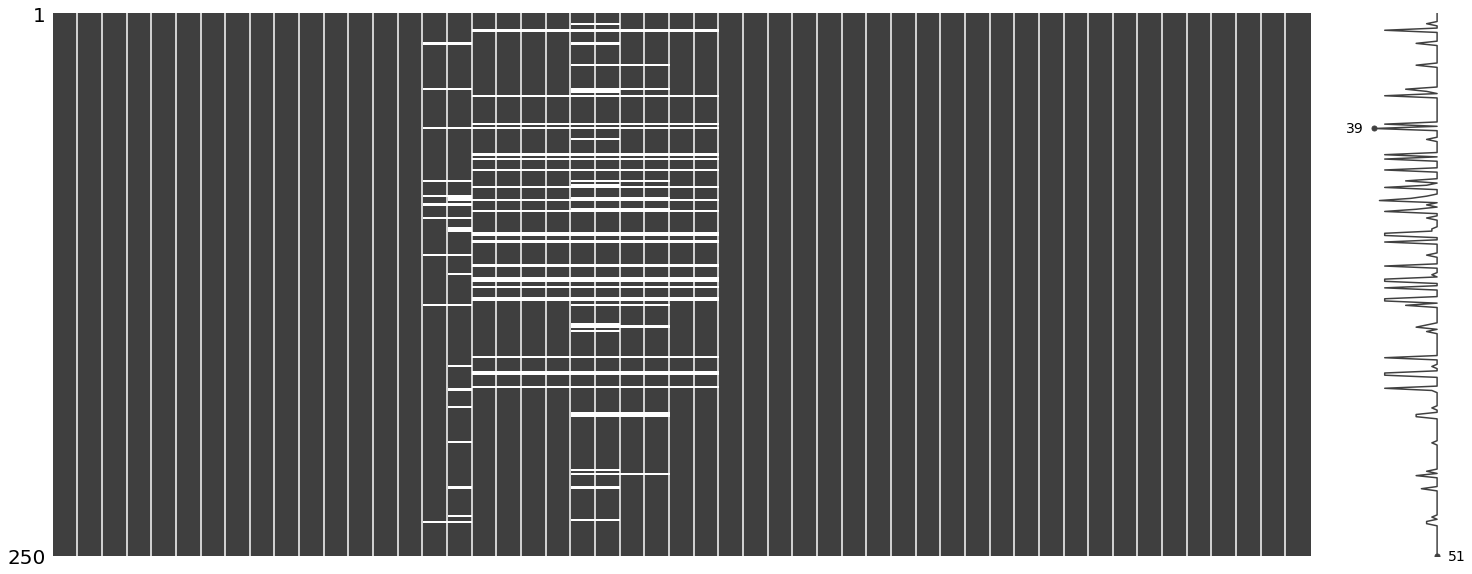

In [35]:
msno.matrix(fit_data.sample(250))

In [36]:
# 数据集划分为训练习、验证集、测试集，建模
data_train, data_test = train_test_split(fit_data, test_size=0.2)
target = data_train['is_pay']
features = data_train.drop(['is_pay'], axis=1)

X_train, x_val, Y_train, y_val = train_test_split(features,target, test_size=0.2)
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"lambda_l1":1.2,
"lambda_l2":0.7,
"metric": "auc",
}

train_data = lgb.Dataset(X_train, label=Y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=2000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.93705	valid_1's auc: 0.928853
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.952486	valid_1's auc: 0.946004
[3]	training's auc: 0.949718	valid_1's auc: 0.942665
[4]	training's auc: 0.950704	valid_1's auc: 0.94395
[5]	training's auc: 0.952826	valid_1's auc: 0.946493
[6]	training's auc: 0.952803	valid_1's auc: 0.946757
[7]	training's auc: 0.95502	valid_1's auc: 0.949069
[8]	training's auc: 0.954595	valid_1's auc: 0.94863
[9]	training's auc: 0.954342	valid_1's auc: 0.948355
[10]	training's auc: 0.954212	valid_1's auc: 0.948279
[11]	training's auc: 0.953637	valid_1's auc: 0.947589
[12]	training's auc: 0.953186	valid_1's auc: 0.947103
[13]	training's auc: 0.952847	valid_1's auc: 0.946648
[14]	training's auc: 0.952948	valid_1's auc: 0.946796
[15]	training's auc: 0.953629	valid_1's auc: 0.947636
[16]	training's auc: 0.954065	valid_1's auc: 0.948109
[17]	training's auc: 0.954655	valid_1's auc: 0.948842
[18]	training's auc: 0.954621	val

[165]	training's auc: 0.957705	valid_1's auc: 0.951813
[166]	training's auc: 0.95771	valid_1's auc: 0.95186
[167]	training's auc: 0.957734	valid_1's auc: 0.951875
[168]	training's auc: 0.95775	valid_1's auc: 0.951872
[169]	training's auc: 0.957768	valid_1's auc: 0.951889
[170]	training's auc: 0.957787	valid_1's auc: 0.951904
[171]	training's auc: 0.957788	valid_1's auc: 0.9519
[172]	training's auc: 0.957785	valid_1's auc: 0.951896
[173]	training's auc: 0.957791	valid_1's auc: 0.951895
[174]	training's auc: 0.957791	valid_1's auc: 0.95189
[175]	training's auc: 0.957818	valid_1's auc: 0.951916
[176]	training's auc: 0.957854	valid_1's auc: 0.951984
[177]	training's auc: 0.957863	valid_1's auc: 0.95198
[178]	training's auc: 0.957887	valid_1's auc: 0.952002
[179]	training's auc: 0.957904	valid_1's auc: 0.95202
[180]	training's auc: 0.957906	valid_1's auc: 0.95202
[181]	training's auc: 0.957909	valid_1's auc: 0.952024
[182]	training's auc: 0.95793	valid_1's auc: 0.952042
[183]	training's auc

[328]	training's auc: 0.960063	valid_1's auc: 0.953412
[329]	training's auc: 0.960076	valid_1's auc: 0.953419
[330]	training's auc: 0.960088	valid_1's auc: 0.953428
[331]	training's auc: 0.9601	valid_1's auc: 0.953433
[332]	training's auc: 0.96012	valid_1's auc: 0.953455
[333]	training's auc: 0.960128	valid_1's auc: 0.953458
[334]	training's auc: 0.960146	valid_1's auc: 0.953462
[335]	training's auc: 0.960158	valid_1's auc: 0.953468
[336]	training's auc: 0.960166	valid_1's auc: 0.95347
[337]	training's auc: 0.960178	valid_1's auc: 0.953483
[338]	training's auc: 0.960189	valid_1's auc: 0.953489
[339]	training's auc: 0.960199	valid_1's auc: 0.953493
[340]	training's auc: 0.960215	valid_1's auc: 0.953502
[341]	training's auc: 0.960228	valid_1's auc: 0.953514
[342]	training's auc: 0.96024	valid_1's auc: 0.95352
[343]	training's auc: 0.960248	valid_1's auc: 0.953522
[344]	training's auc: 0.960256	valid_1's auc: 0.95352
[345]	training's auc: 0.960278	valid_1's auc: 0.953538
[346]	training's 

[508]	training's auc: 0.962168	valid_1's auc: 0.954591
[509]	training's auc: 0.962177	valid_1's auc: 0.954597
[510]	training's auc: 0.962189	valid_1's auc: 0.954607
[511]	training's auc: 0.962199	valid_1's auc: 0.95461
[512]	training's auc: 0.962205	valid_1's auc: 0.954612
[513]	training's auc: 0.962214	valid_1's auc: 0.95461
[514]	training's auc: 0.962224	valid_1's auc: 0.954612
[515]	training's auc: 0.962233	valid_1's auc: 0.954616
[516]	training's auc: 0.962242	valid_1's auc: 0.954619
[517]	training's auc: 0.96225	valid_1's auc: 0.954622
[518]	training's auc: 0.962264	valid_1's auc: 0.954631
[519]	training's auc: 0.962276	valid_1's auc: 0.954642
[520]	training's auc: 0.962289	valid_1's auc: 0.954654
[521]	training's auc: 0.962298	valid_1's auc: 0.954658
[522]	training's auc: 0.962307	valid_1's auc: 0.954659
[523]	training's auc: 0.962316	valid_1's auc: 0.954662
[524]	training's auc: 0.962324	valid_1's auc: 0.954668
[525]	training's auc: 0.962336	valid_1's auc: 0.954674
[526]	trainin

[657]	training's auc: 0.96359	valid_1's auc: 0.955112
[658]	training's auc: 0.963598	valid_1's auc: 0.955113
[659]	training's auc: 0.963608	valid_1's auc: 0.955119
[660]	training's auc: 0.963618	valid_1's auc: 0.955123
[661]	training's auc: 0.963625	valid_1's auc: 0.955125
[662]	training's auc: 0.963632	valid_1's auc: 0.955128
[663]	training's auc: 0.963639	valid_1's auc: 0.955128
[664]	training's auc: 0.963647	valid_1's auc: 0.955125
[665]	training's auc: 0.963655	valid_1's auc: 0.955125
[666]	training's auc: 0.963664	valid_1's auc: 0.955127
[667]	training's auc: 0.963674	valid_1's auc: 0.955129
[668]	training's auc: 0.963684	valid_1's auc: 0.955132
[669]	training's auc: 0.96369	valid_1's auc: 0.955133
[670]	training's auc: 0.963701	valid_1's auc: 0.955136
[671]	training's auc: 0.963712	valid_1's auc: 0.955138
[672]	training's auc: 0.963722	valid_1's auc: 0.955141
[673]	training's auc: 0.963731	valid_1's auc: 0.955144
[674]	training's auc: 0.963742	valid_1's auc: 0.955146
[675]	traini

[806]	training's auc: 0.964794	valid_1's auc: 0.955383
[807]	training's auc: 0.964801	valid_1's auc: 0.955382
[808]	training's auc: 0.964809	valid_1's auc: 0.955383
[809]	training's auc: 0.964822	valid_1's auc: 0.955389
[810]	training's auc: 0.964827	valid_1's auc: 0.955388
[811]	training's auc: 0.964834	valid_1's auc: 0.955389
[812]	training's auc: 0.96484	valid_1's auc: 0.955388
[813]	training's auc: 0.964846	valid_1's auc: 0.955388
[814]	training's auc: 0.964853	valid_1's auc: 0.955391
[815]	training's auc: 0.964861	valid_1's auc: 0.955395
[816]	training's auc: 0.964869	valid_1's auc: 0.955393
[817]	training's auc: 0.964879	valid_1's auc: 0.955399
[818]	training's auc: 0.964888	valid_1's auc: 0.955406
[819]	training's auc: 0.964898	valid_1's auc: 0.955405
[820]	training's auc: 0.964901	valid_1's auc: 0.955406
[821]	training's auc: 0.964908	valid_1's auc: 0.955406
[822]	training's auc: 0.964915	valid_1's auc: 0.955408
[823]	training's auc: 0.964921	valid_1's auc: 0.955407
[824]	train

[963]	training's auc: 0.965937	valid_1's auc: 0.955598
[964]	training's auc: 0.965945	valid_1's auc: 0.955596
[965]	training's auc: 0.965953	valid_1's auc: 0.955596
[966]	training's auc: 0.965957	valid_1's auc: 0.955597
[967]	training's auc: 0.965964	valid_1's auc: 0.955597
[968]	training's auc: 0.965969	valid_1's auc: 0.955598
[969]	training's auc: 0.965975	valid_1's auc: 0.955599
[970]	training's auc: 0.965983	valid_1's auc: 0.955602
[971]	training's auc: 0.965989	valid_1's auc: 0.955602
[972]	training's auc: 0.965994	valid_1's auc: 0.955603
[973]	training's auc: 0.966003	valid_1's auc: 0.955603
[974]	training's auc: 0.966009	valid_1's auc: 0.955602
[975]	training's auc: 0.966017	valid_1's auc: 0.955603
[976]	training's auc: 0.966022	valid_1's auc: 0.955602
[977]	training's auc: 0.966027	valid_1's auc: 0.955604
[978]	training's auc: 0.966034	valid_1's auc: 0.955607
[979]	training's auc: 0.96604	valid_1's auc: 0.955608
[980]	training's auc: 0.96605	valid_1's auc: 0.955608
[981]	traini

[1138]	training's auc: 0.967166	valid_1's auc: 0.955762
[1139]	training's auc: 0.967174	valid_1's auc: 0.955761
[1140]	training's auc: 0.967179	valid_1's auc: 0.955764
[1141]	training's auc: 0.967186	valid_1's auc: 0.955763
[1142]	training's auc: 0.967193	valid_1's auc: 0.955759
[1143]	training's auc: 0.967198	valid_1's auc: 0.955758
[1144]	training's auc: 0.967206	valid_1's auc: 0.95576
[1145]	training's auc: 0.967214	valid_1's auc: 0.955762
[1146]	training's auc: 0.967219	valid_1's auc: 0.955761
[1147]	training's auc: 0.967226	valid_1's auc: 0.955762
[1148]	training's auc: 0.967232	valid_1's auc: 0.955764
[1149]	training's auc: 0.967241	valid_1's auc: 0.955766
[1150]	training's auc: 0.967249	valid_1's auc: 0.955769
[1151]	training's auc: 0.967255	valid_1's auc: 0.95577
[1152]	training's auc: 0.967259	valid_1's auc: 0.95577
[1153]	training's auc: 0.967269	valid_1's auc: 0.955771
[1154]	training's auc: 0.967274	valid_1's auc: 0.955772
[1155]	training's auc: 0.967282	valid_1's auc: 0.95

[1288]	training's auc: 0.968137	valid_1's auc: 0.95583
[1289]	training's auc: 0.968145	valid_1's auc: 0.955831
[1290]	training's auc: 0.96815	valid_1's auc: 0.955833
[1291]	training's auc: 0.968157	valid_1's auc: 0.955835
[1292]	training's auc: 0.968164	valid_1's auc: 0.955837
[1293]	training's auc: 0.968167	valid_1's auc: 0.955838
[1294]	training's auc: 0.968172	valid_1's auc: 0.955837
[1295]	training's auc: 0.968177	valid_1's auc: 0.955838
[1296]	training's auc: 0.968184	valid_1's auc: 0.955837
[1297]	training's auc: 0.96819	valid_1's auc: 0.955837
[1298]	training's auc: 0.968198	valid_1's auc: 0.955837
[1299]	training's auc: 0.968204	valid_1's auc: 0.955837
[1300]	training's auc: 0.968211	valid_1's auc: 0.955838
[1301]	training's auc: 0.968217	valid_1's auc: 0.955841
[1302]	training's auc: 0.968226	valid_1's auc: 0.955841
[1303]	training's auc: 0.96823	valid_1's auc: 0.95584
[1304]	training's auc: 0.968237	valid_1's auc: 0.955841
[1305]	training's auc: 0.968242	valid_1's auc: 0.9558

[1463]	training's auc: 0.969188	valid_1's auc: 0.955902
[1464]	training's auc: 0.969196	valid_1's auc: 0.955902
[1465]	training's auc: 0.969202	valid_1's auc: 0.955903
[1466]	training's auc: 0.969207	valid_1's auc: 0.955899
[1467]	training's auc: 0.969211	valid_1's auc: 0.955899
[1468]	training's auc: 0.969215	valid_1's auc: 0.955899
[1469]	training's auc: 0.969222	valid_1's auc: 0.955898
[1470]	training's auc: 0.969227	valid_1's auc: 0.955897
[1471]	training's auc: 0.969234	valid_1's auc: 0.955899
[1472]	training's auc: 0.969239	valid_1's auc: 0.9559
[1473]	training's auc: 0.969245	valid_1's auc: 0.955901
[1474]	training's auc: 0.969252	valid_1's auc: 0.955899
[1475]	training's auc: 0.969258	valid_1's auc: 0.955898
[1476]	training's auc: 0.969263	valid_1's auc: 0.955897
[1477]	training's auc: 0.969267	valid_1's auc: 0.955898
[1478]	training's auc: 0.969273	valid_1's auc: 0.955899
[1479]	training's auc: 0.96928	valid_1's auc: 0.955901
[1480]	training's auc: 0.969287	valid_1's auc: 0.95

[1639]	training's auc: 0.970181	valid_1's auc: 0.955968
[1640]	training's auc: 0.970185	valid_1's auc: 0.955966
[1641]	training's auc: 0.97019	valid_1's auc: 0.955969
[1642]	training's auc: 0.970195	valid_1's auc: 0.955969
[1643]	training's auc: 0.970201	valid_1's auc: 0.955969
[1644]	training's auc: 0.970208	valid_1's auc: 0.95597
[1645]	training's auc: 0.970211	valid_1's auc: 0.95597
[1646]	training's auc: 0.970215	valid_1's auc: 0.95597
[1647]	training's auc: 0.970222	valid_1's auc: 0.955972
[1648]	training's auc: 0.970228	valid_1's auc: 0.955973
[1649]	training's auc: 0.970235	valid_1's auc: 0.955971
[1650]	training's auc: 0.970241	valid_1's auc: 0.95597
[1651]	training's auc: 0.970244	valid_1's auc: 0.95597
[1652]	training's auc: 0.970248	valid_1's auc: 0.955969
[1653]	training's auc: 0.970255	valid_1's auc: 0.95597
[1654]	training's auc: 0.970259	valid_1's auc: 0.95597
[1655]	training's auc: 0.970264	valid_1's auc: 0.955969
[1656]	training's auc: 0.970269	valid_1's auc: 0.955971


[1822]	training's auc: 0.971157	valid_1's auc: 0.955991
[1823]	training's auc: 0.971164	valid_1's auc: 0.95599
[1824]	training's auc: 0.97117	valid_1's auc: 0.955992
[1825]	training's auc: 0.971176	valid_1's auc: 0.955991
[1826]	training's auc: 0.971181	valid_1's auc: 0.95599
[1827]	training's auc: 0.971184	valid_1's auc: 0.95599
[1828]	training's auc: 0.971188	valid_1's auc: 0.955988
[1829]	training's auc: 0.971195	valid_1's auc: 0.95599
[1830]	training's auc: 0.971202	valid_1's auc: 0.955991
[1831]	training's auc: 0.971208	valid_1's auc: 0.955992
[1832]	training's auc: 0.971213	valid_1's auc: 0.955994
[1833]	training's auc: 0.97122	valid_1's auc: 0.955996
[1834]	training's auc: 0.971227	valid_1's auc: 0.955995
[1835]	training's auc: 0.971234	valid_1's auc: 0.955994
[1836]	training's auc: 0.971238	valid_1's auc: 0.955993
[1837]	training's auc: 0.971244	valid_1's auc: 0.955994
[1838]	training's auc: 0.971249	valid_1's auc: 0.955995
[1839]	training's auc: 0.971255	valid_1's auc: 0.95599

[1998]	training's auc: 0.972121	valid_1's auc: 0.956013
[1999]	training's auc: 0.972126	valid_1's auc: 0.956013
[2000]	training's auc: 0.972128	valid_1's auc: 0.956014
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.972128	valid_1's auc: 0.956014


In [37]:
# 验证集上的准确率
y_predict_val = model.predict(x_val)
sessoin = pd.DataFrame(y_predict_val, columns=['is_pay'])
sessoin['is_pay']=sessoin['is_pay'].apply(lambda x:1 if x>=0.5 else 0)
y_predict_val = sessoin['is_pay'].values
print(recall_score(y_val, y_predict_val, average=None))

[0.9176397  0.83074825]


In [38]:
target_test = data_test['is_pay']
features_test = data_test.drop(['is_pay'], axis=1)
# 测试集上的准确率
y_predict_test = model.predict(features_test)
sessoin_test = pd.DataFrame(y_predict_test, columns=['is_pay'])
sessoin_test['is_pay']=sessoin_test['is_pay'].apply(lambda x:1 if x>=0.5 else 0)
y_predict_test = sessoin_test['is_pay'].values

In [39]:
print(precision_score(target_test, y_predict_test))
print(recall_score(target_test, y_predict_test, average=None))
print(accuracy_score(target_test, y_predict_test))
# print(auc(target_test, y_predict_test))
print(f1_score(target_test, y_predict_test))

0.8662865288667142
[0.92181379 0.82951133]
0.8868188169538892
0.8475001743253608


In [40]:
print(classification_report(target_test, y_predict_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     11997
           1       0.87      0.83      0.85      7326

    accuracy                           0.89     19323
   macro avg       0.88      0.88      0.88     19323
weighted avg       0.89      0.89      0.89     19323



<Figure size 864x432 with 0 Axes>

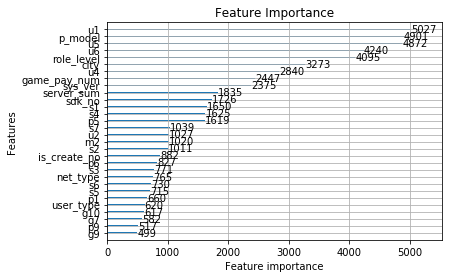

In [50]:
import matplotlib.pylab as plt
plt.figure(figsize=(12,6))
lgb.plot_importance(model, max_num_features=30)
plt.title('Feature Importance')
plt.show()

In [57]:
import joblib

In [58]:
joblib.dump(model, './gbm_model.m')

['./gbm_model.m']